
# Bayesian Optimality Analysis

Implements your PI's requested steps (1a–1e) on `trials_clean.csv`.

**What this notebook does:**
- Computes the posterior distribution over the true probability $P_T$ given each trial's target frequency (tf = k/n), using a **uniform prior** (Beta(1,1)).
- Computes the **Bayes-optimal decision** for each trial: choose "higher" if $P(P_T>T\mid tf) > 0.5$, else "lower".
- Compares participants' choices to the Bayes-optimal choice to obtain **% optimal** per participant.
- Saves trial-level and participant-level outputs to `derived/`.
- (Optional) Visualizes a few example posteriors.

> Notes: With a uniform prior, the posterior is **Beta(k+1, n−k+1)**. Integrals like $P(P_T>T\mid tf)$ are computed via the Beta CDF.


In [ ]:
# --- Paths & imports bootstrap ---
import sys
from pathlib import Path

def find_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "src").exists() and (p / "notebooks").exists():
            return p
    return start

ROOT = find_root(Path.cwd())
SRC = ROOT / "src"
DERIVED = ROOT / "derived"
FIG = ROOT / "figures"
DERIVED.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

# Make src importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Import the module you moved
from bayes_optimal import (
    Prior, binomial_likelihood, posterior_grid, posterior_prob_gt_threshold,
    bayes_optimal_decision, autodetect_columns, coerce_choice_to_label
)

print("ROOT:", ROOT)
print("Using bayes_optimal from:", (SRC / "bayes_optimal.py"))


ROOT: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis


In [9]:
from pathlib import Path
import os, sys, difflib

print("ROOT:", ROOT)
print("DERIVED:", DERIVED, "is_dir:", DERIVED.is_dir(), "exists:", DERIVED.exists())

names = [p.name for p in DERIVED.iterdir()] if DERIVED.exists() else []
print("Count in derived/:", len(names))
for n in names:
    print(" -", repr(n))

# Helpful: closest matches to our expected filename
target = "trials_clean.csv"
print("\nClosest matches to", repr(target), "=>", difflib.get_close_matches(target, names, n=3))


ROOT: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis
DERIVED: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/derived is_dir: True exists: True
Count in derived/: 0

Closest matches to 'trials_clean.csv' => []


In [10]:
import pandas as pd
from pathlib import Path
import difflib

expected = DERIVED / "trials_clean.csv"

TRIALS_PATH = None
if expected.exists():
    TRIALS_PATH = expected
else:
    # fuzzy match inside derived/
    cand = list(DERIVED.glob("*.csv"))
    if cand:
        names = [c.name for c in cand]
        best = difflib.get_close_matches("trials_clean.csv", names, n=1)
        if best:
            TRIALS_PATH = DERIVED / best[0]

# fallback: search entire repo
if TRIALS_PATH is None:
    cands = list(ROOT.rglob("trials_clean.csv"))
    if cands:
        TRIALS_PATH = cands[0]

if TRIALS_PATH is None:
    raise FileNotFoundError(
        "Kernel cannot see trials_clean.csv in derived/. "
        "If Terminal shows it, this is likely a macOS permission issue (VS Code/Jupyter "
        "lacks Full Disk Access) or a filename encoding mismatch.\n\n"
        "Fix options:\n"
        "  1) Give VS Code Full Disk Access: System Settings → Privacy & Security → Full Disk Access → add VS Code.\n"
        "  2) Move the repo under a neutral folder (e.g., ~/code/) and retry.\n"
        "  3) Rename the file in Terminal: `mv -f 'trials_clean.csv' trials_clean.csv`.\n"
        "  4) Hardcode the absolute path below."
    )

print("Loading:", TRIALS_PATH)
df = pd.read_csv(TRIALS_PATH)
print("Loaded shape:", df.shape)
df.head(3)


Loading: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/data/derived/trials_clean.csv
Loaded shape: (1780, 21)


,sessionId,participantId,trial_index,probability,respondedAt,rsvpStart,correct,response,sequence,responseStart,...,threshold,set,promptStart,timestamp,delta,abs_delta,is_higher,correct_int,difficulty,rt_win
0,4d8eaee7-2830-49bd-adca-379557640812,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,0,0.3,2025-08-08T17:34:56.970Z,2025-08-08T17:34:47.236Z,True,higher,"['/assets/plane-c0dbff1b.png', '/assets/plane-...",2025-08-08T17:34:50.307Z,...,0.0,4,2025-08-08T17:34:43.983Z,2025-08-08T17:34:56.970Z,0.3,0.3,1,1,0.7,4933.09
1,4d8eaee7-2830-49bd-adca-379557640812,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,1,0.4,2025-08-08T17:35:06.516Z,2025-08-08T17:35:01.605Z,False,higher,"['/assets/red_square-4f316577.png', '/assets/g...",2025-08-08T17:35:04.668Z,...,0.4,2,2025-08-08T17:34:59.057Z,2025-08-08T17:35:06.516Z,0.0,0.0,1,0,1.0,1847.00
2,4d8eaee7-2830-49bd-adca-379557640812,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,2,0.8,2025-08-08T17:35:14.688Z,2025-08-08T17:35:09.931Z,True,higher,"['/assets/blue_rectangle-7fb8194b.png', '/asse...",2025-08-08T17:35:12.991Z,...,0.7,1,2025-08-08T17:35:07.526Z,2025-08-08T17:35:14.688Z,0.1,0.1,1,1,0.9,1697.00


In [11]:
# --- Normalize location: keep a canonical copy in DERIVED ---
from pathlib import Path
import shutil

canonical = DERIVED / "trials_clean.csv"
if TRIALS_PATH.resolve() != canonical.resolve():
    canonical.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(TRIALS_PATH, canonical)
    print("Copied to:", canonical)
else:
    print("Already canonical at:", canonical)

# From here on, use the canonical path:
TRIALS_PATH = canonical


Copied to: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/derived/trials_clean.csv


In [12]:
# --- Configure / autodetect columns ---
# We know our dataset; still run autodetect with hints for robustness.
hints = {
    'participant_id': 'participantId',
    'threshold': 'threshold',
    'choice': 'response',
    'rt': 'rt',
    # we will derive k/n from 'sequence', so we don't need these two:
    'target_count': None,
    'n_samples': None,
}
cols = autodetect_columns(df, hints)
cols


{'participant_id': 'participantId',
 'threshold': 'threshold',
 'choice': 'response',
 'rt': 'rt',
 'target_count': None,
 'n_samples': None}

In [13]:
# --- Derive k (target successes), n (samples), tf from `sequence` ---
# `sequence` is a Python-list string of filepaths like '/assets/blue_rectangle-xyz.png'.
import ast

def extract_label(path: str) -> str:
    name = Path(path).name                # e.g., 'blue_rectangle-7fb8194b.png'
    base = name.split('.')[0].split('-')[0]
    return base

def parse_sequence(seq_str: str):
    try:
        seq = ast.literal_eval(seq_str)
        labels = [extract_label(p) for p in seq]
        return labels
    except Exception:
        return None

k_list, n_list, target_label_list = [], [], []
for seq_str, p_true in zip(df['sequence'], df['probability']):
    labels = parse_sequence(seq_str)
    if not labels:
        k_list.append(np.nan); n_list.append(np.nan); target_label_list.append(None); continue
    n = len(labels)
    vals, counts = np.unique(labels, return_counts=True)
    props = counts / n
    # infer which label is the "target" by matching the trial's true probability
    idx = int(np.argmin(np.abs(props - p_true)))
    k = int(counts[idx])
    target_label = vals[idx]
    k_list.append(k); n_list.append(n); target_label_list.append(target_label)

df['k'] = k_list
df['n'] = n_list
df['tf'] = df['k'] / df['n']
df['target_label_inferred'] = target_label_list

# Sanity checks
assert df['k'].notna().all() and df['n'].notna().all(), "Could not derive k/n for some trials."
assert (df['n'] > 0).all(), "n must be positive."

df[['participantId','trial_index','probability','threshold','k','n','tf','target_label_inferred']].head(8)


,participantId,trial_index,probability,threshold,k,n,tf,target_label_inferred
0,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,0,0.3,0.0,6,20,0.30,car
1,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,1,0.4,0.4,10,20,0.50,green_circle
2,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,2,0.8,0.7,16,20,0.80,blue_rectangle
3,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,3,0.4,0.2,7,20,0.35,green_circle
4,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,4,0.7,1.0,14,20,0.70,green_circle
5,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,5,0.8,0.7,17,20,0.85,blue_rectangle
6,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,6,0.9,0.5,17,20,0.85,blue_rectangle
7,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,7,0.6,0.9,13,20,0.65,blue_rectangle


In [14]:
# --- Compute Bayes-optimal decision per trial (uniform prior Beta(1,1)) ---
prior = Prior(a=1.0, b=1.0)
thr_col = cols['threshold']
assert thr_col in df.columns, f"Threshold column '{thr_col}' not found."

decisions, p_gt, p_lt, ties = [], [], [], []
for k, n, T in zip(df['k'].astype(int), df['n'].astype(int), df[thr_col].astype(float)):
    d, a, b, t = bayes_optimal_decision(k, n, T, prior=prior)
    decisions.append(d); p_gt.append(a); p_lt.append(b); ties.append(t)

df['bayes_opt_choice'] = decisions
df['bayes_post_p_gt_T'] = p_gt
df['bayes_post_p_lt_T'] = p_lt
df['bayes_is_tie'] = ties
df['bayes_confidence'] = (df['bayes_post_p_gt_T'] - df['bayes_post_p_lt_T']).abs()

df[['trial_index','probability',thr_col,'k','n','tf','bayes_opt_choice','bayes_post_p_gt_T','bayes_confidence']].head(10)


,trial_index,probability,threshold,k,n,tf,bayes_opt_choice,bayes_post_p_gt_T,bayes_confidence
0,0,0.3,0.0,6,20,0.30,higher,1.000000,1.000000
1,1,0.4,0.4,10,20,0.50,higher,0.825622,0.651244
2,2,0.8,0.7,16,20,0.80,higher,0.801619,0.603237
3,3,0.4,0.2,7,20,0.35,higher,0.956947,0.913895
4,4,0.7,1.0,14,20,0.70,lower,0.000000,1.000000
5,5,0.8,0.7,17,20,0.85,higher,0.914394,0.828789
6,6,0.9,0.5,17,20,0.85,higher,0.999255,0.998510
7,7,0.6,0.9,13,20,0.65,lower,0.000613,0.998775
8,8,1.0,0.4,20,20,1.00,higher,1.000000,1.000000
9,9,0.9,0.0,19,20,0.95,higher,1.000000,1.000000


In [15]:
# --- Compare to participant choices; save trial-level output ---
choice_col = cols['choice']
df['choice_label'] = df[choice_col].apply(coerce_choice_to_label)
missing = df['choice_label'].isna().mean()
if missing > 0:
    print(f"Warning: {missing:.1%} of trials have unmapped choice labels.")

df['is_optimal'] = (df['choice_label'] == df['bayes_opt_choice'])

trial_out = DERIVED / "bayes_optimal_trials.csv"
df.to_csv(trial_out, index=False)
print("Saved trial-level output:", trial_out)

df[['participantId','trial_index','choice_label','bayes_opt_choice','is_optimal']].head(10)


Saved trial-level output: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/derived/bayes_optimal_trials.csv


,participantId,trial_index,choice_label,bayes_opt_choice,is_optimal
0,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,0,higher,higher,True
1,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,1,higher,higher,True
2,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,2,higher,higher,True
3,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,3,lower,higher,False
4,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,4,lower,lower,True
5,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,5,higher,higher,True
6,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,6,higher,higher,True
7,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,7,lower,lower,True
8,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,8,higher,higher,True
9,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,9,higher,higher,True


In [16]:
# --- Participant-level summary; save ---
pid_col = cols['participant_id']
summary = df.groupby(pid_col).agg(
    n_trials=('bayes_opt_choice','size'),
    pct_optimal=('is_optimal', lambda x: float(np.mean(x))*100 if x.notna().any() else np.nan),
    median_confidence=('bayes_confidence','median'),
    acc=('correct', 'mean'),
    rt_median=('rt', 'median')
).reset_index()

summ_out = DERIVED / "bayes_optimal_summary.csv"
summary.to_csv(summ_out, index=False)
display(summary)
print("Saved summary:", summ_out)


,participantId,n_trials,pct_optimal,median_confidence,acc,rt_median
0,44ab8d9a-01ff-4cb3-8676-c933a77b7207,445,93.033708,0.999779,0.912360,785.0
1,696e0e3f-da68-4178-8d5b-43ea5aaefadd,445,86.067416,0.999935,0.851685,1188.0
2,7a85d59e-1e5c-4d1d-8dc1-5c866967a30f,445,87.415730,0.999690,0.858427,891.0
3,abbf0f48-70cd-4589-8b1f-6570cee03296,445,84.719101,0.999612,0.842697,1073.0


Saved summary: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/derived/bayes_optimal_summary.csv


In [17]:
# --- RT vs Bayesian difficulty correlation (Spearman) ---
try:
    from scipy.stats import spearmanr
    df['bayes_difficulty'] = 1.0 - df['bayes_confidence']
    valid = df[['rt','bayes_difficulty']].dropna()
    if len(valid) >= 3:
        rho, pval = spearmanr(valid['rt'], valid['bayes_difficulty'])
        print(f"Spearman RT vs Bayesian difficulty: rho={rho:.3f}, p={pval:.3g}, n={len(valid)}")
    else:
        print("Not enough data for RT correlation.")
except Exception as e:
    print("Skipping correlation (scipy missing or other error):", e)


Spearman RT vs Bayesian difficulty: rho=0.231, p=4.66e-23, n=1780


Saved: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/figures/bayes_posterior_example.png


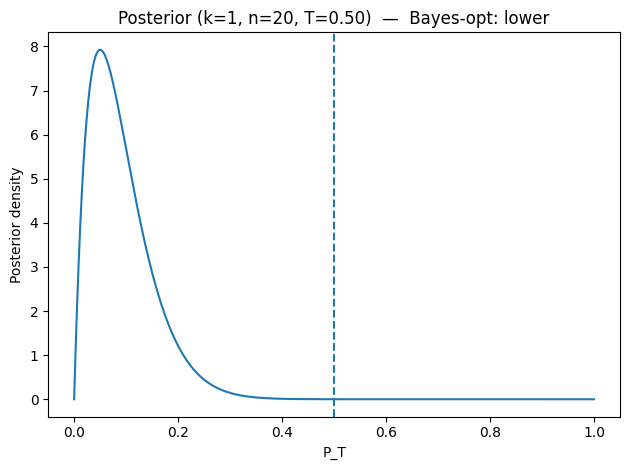

In [18]:
# --- Example posterior plot for one random trial ---
grid = np.linspace(0, 1, 1001)
row = df.sample(1, random_state=42).iloc[0]
k, n, T = int(row['k']), int(row['n']), float(row[thr_col])
post = posterior_grid(k, n, grid, prior=prior)

plt.figure()
plt.plot(grid, post)
plt.axvline(T, linestyle='--')
plt.xlabel("P_T")
plt.ylabel("Posterior density")
plt.title(f"Posterior (k={k}, n={n}, T={T:.2f})  —  Bayes-opt: {row['bayes_opt_choice']}")
out_fig = FIG / "bayes_posterior_example.png"
plt.tight_layout()
plt.savefig(out_fig, dpi=150, bbox_inches='tight')
print("Saved:", out_fig)


Saved: /Users/mihirrelan/Stuphorn/03_Fall2025/react-probability-task-data-analysis/figures/optimality_vs_absdelta.png


/var/folders/9s/k3_b_6ln6h161s557r34sr_80000gn/T/ipykernel_5768/221676424.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby('abs_delta_bin')['is_optimal'].mean().mul(100).reset_index()


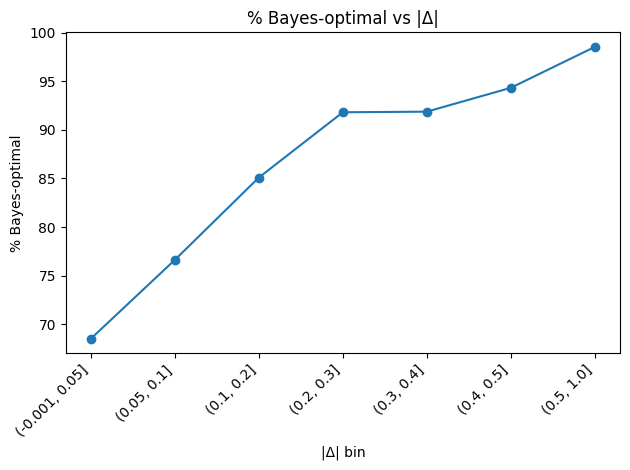

In [19]:
# --- % Bayes-optimal vs |Δ| ---
bins = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
df['abs_delta_bin'] = pd.cut(df['abs_delta'], bins=bins, include_lowest=True, right=True)

g = df.groupby('abs_delta_bin')['is_optimal'].mean().mul(100).reset_index()

plt.figure()
plt.plot(range(len(g)), g['is_optimal'], marker='o')
plt.xticks(range(len(g)), [str(b) for b in g['abs_delta_bin']], rotation=45, ha='right')
plt.xlabel("|Δ| bin")
plt.ylabel("% Bayes-optimal")
plt.title("% Bayes-optimal vs |Δ|")
out_fig2 = FIG / "optimality_vs_absdelta.png"
plt.tight_layout()
plt.savefig(out_fig2, dpi=150, bbox_inches='tight')
print("Saved:", out_fig2)
